In [39]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
from src.utils import flatten_level_columns as flc
from src.utils import read_netmhcpan_results, filter_rank, get_filtered_df
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)
from sklearn.metrics import roc_auc_score, roc_curve

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# init

In [40]:
# Re-reading the core alignment data from the NNalign outputs
DATADIR = '../data/'
NNDIR='../../../nnalign/output/'

In [41]:
sns.color_palette('hsv', n_colors = 13)

[(1.0, 0.4169121816180639, 0.0),
 (1.0, 0.8338243632361279, 0.0),
 (0.7492634551458082, 1.0, 0.0),
 (0.309189485660074, 1.0, 0.0),
 (0.0, 1.0, 0.10772241105651532),
 (0.0, 1.0, 0.5246319661417559),
 (0.0, 1.0, 0.9647031631761764),
 (0.0, 0.6183848775760541, 1.0),
 (0.0, 0.201472695957991, 1.0),
 (0.2154394856600736, 0.0, 1.0),
 (0.6555134551458082, 0.0, 1.0),
 (1.0, 0.0, 0.9275743632361277),
 (1.0, 0.0, 0.5106621816180639)]

In [53]:
palette=sns.color_palette('hsv', n_colors = 13)
n4=[palette[x] for x in [0, 3, 8, -1]]
n3=[palette[x] for x in [-5, -3, -1]]
n2=[palette[-5], palette[-1]]

# load data

In [44]:
neoepi_scored = pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')
concat_scored = pd.read_csv('../data/cedar_concat_scored.csv')

neoepi_core = pd.read_csv(f'{NNDIR}cedar_neoepitope_220701_scored.pep_3555/cedar_neoepitope_220701_scored.pep_3555.lg6.sorted.pred',
                         sep = '\t')
refined_core = pd.read_csv(f'{NNDIR}cedar_neoepitope_220701_scored_refined.pep_37890/cedar_neoepitope_220701_scored_refined.pep_37890.lg6.sorted.pred',
                           sep ='\t')
concat_core = pd.read_csv(f'{NNDIR}cedar_concat_scored.pep_4785/cedar_concat_scored.pep_4785.lg6.sorted.pred', sep = '\t')

neoepi_core.assign(label=neoepi_core['Measure'].astype(int))
refined_core.assign(label=refined_core['Measure'].astype(int))
concat_core.assign(label=concat_core['Measure'].astype(int))


neoepi_core= neoepi_core.merge(neoepi_scored, left_on='Peptide', right_on='Peptide')
refined_core= refined_core.merge(neoepi_scored, left_on='Peptide', right_on='Peptide')
concat_core= concat_core.merge(concat_scored, left_on='Peptide', right_on='Peptide')



# rocs

Text(0.5, 0.98, 'Using three models, Using the entire dataset & different scoring methods')

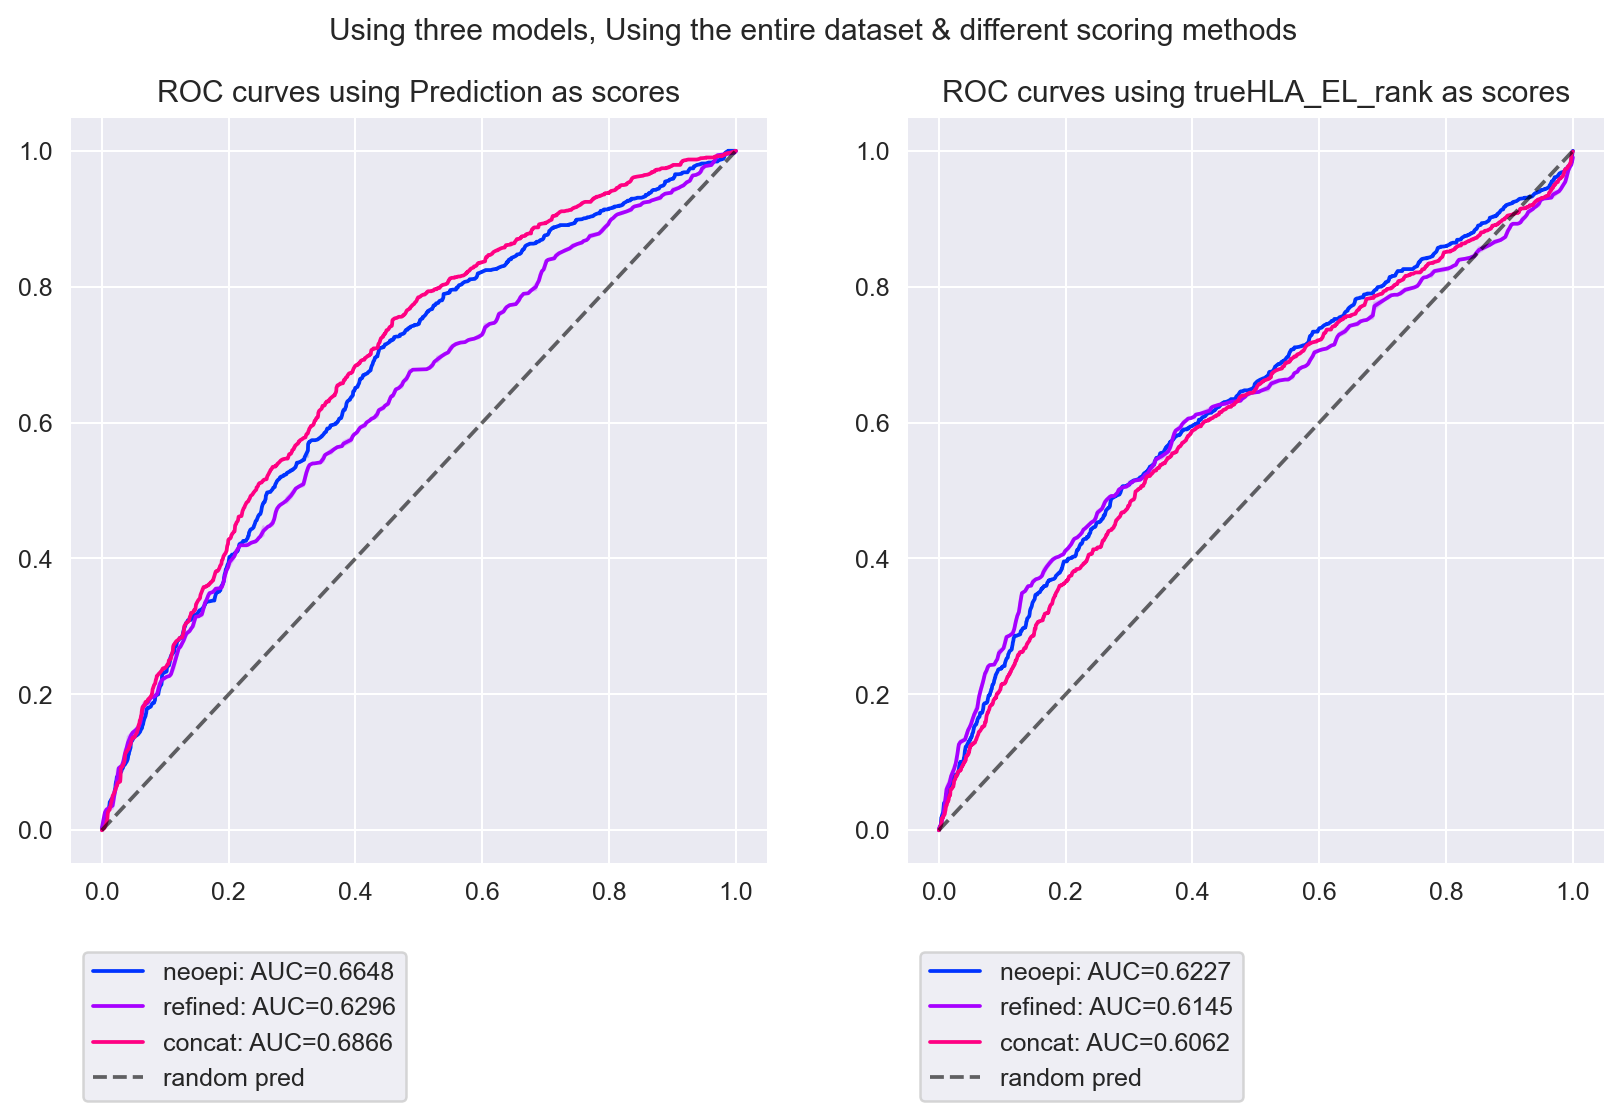

In [55]:
f,a = plt.subplots(1,2, figsize=(11,5.5))
sns.set_palette(n3)
results = {'neoepi':neoepi_core,
           'refined':refined_core,
           'concat': concat_core}

for i, scoring in enumerate(['Prediction', 'trueHLA_EL_rank']):#, 'pred_EL_rank']):
    sign = 1 if scoring =='Prediction' else -1
    for k in results.keys():
        tmp = results[k]
        y_true = tmp['agg_label']
        scores = tmp[scoring]*sign
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)
        sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc.round(4)}', ax = a[i], n_boot=500, palette=n4)
        a[i].set_title(f'ROC curves using {scoring} as scores')
    sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a[i])
    a[i].legend(bbox_to_anchor=(.5,-.1))
f.suptitle('Using three models, Using the entire dataset & different scoring methods')

Text(0.5, 0.98, 'Using three models, all queried on the same subset of peptides and different scoring methods')

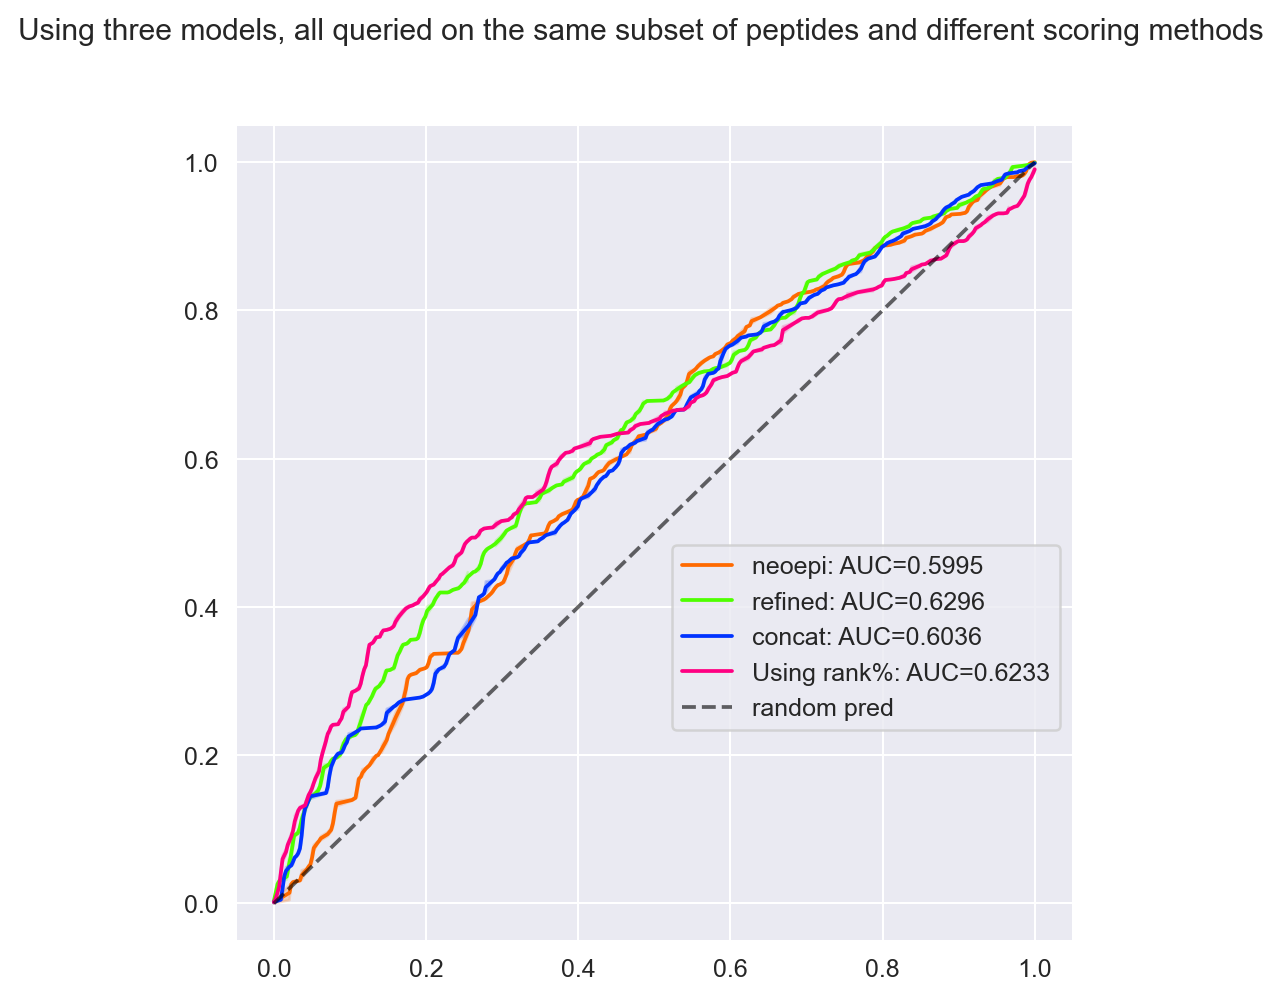

In [62]:
f,a = plt.subplots(1,1, figsize=(6,6))
sns.set_palette(n4)
results = {'neoepi':neoepi_core,
           'refined':refined_core,
           'concat': concat_core}
common_peps = [x for x in neoepi_core.Peptide.values if x in refined_core.Peptide.values]
# NN align prediction scores
for k in results.keys():
    tmp = results[k].query('Peptide in @common_peps')
    y_true = tmp['agg_label']
    scores = tmp['Prediction']
    fpr, tpr, _ = roc_curve(y_true, scores)
    auc = roc_auc_score(y_true, scores)
    sns.lineplot(x=fpr, y=tpr, label = f'{k}: AUC={auc.round(4)}', ax = a, n_boot=500, palette=n4)

# NetMHCpan HLA ranks as score
subset=results['neoepi'].query('Peptide in @common_peps')
ranks = subset['trueHLA_EL_rank'].values * -1
y_true = subset['agg_label']
fpr_, tpr_, _ = roc_curve(y_true, ranks)
auc = roc_auc_score(y_true, ranks)
sns.lineplot(x=fpr_, y=tpr_, label = f'Using rank%: AUC={auc.round(4)}', ax=a, n_boot=500, palette=n4)
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a)
a.legend(bbox_to_anchor=(1,.5))
f.suptitle('Using three models, all queried on the same subset of peptides and different scoring methods')
